In [1]:
import pprint as pp
import PySAM

# version must be at least 2.2.2
print(PySAM.__version__)

5.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rainflow
import PySAM.BatteryStateful as bt
import PySAM.BatteryTools as bt_tools


class LifeModel:
    """
    Reference for NMC/Graphite and LMO/LTO life models:
    Guittet, D. Levelized cost of charging of extreme fast charging with stationary LMO/LTO batteries. Journal of Energy Storage. 2024. 
    https://www.sciencedirect.com/science/article/pii/S2352152X2400152X
    """
    def __init__(self, size_kwh, pVars=[], pVals=[]) -> None:
        self.size_kwh = size_kwh
        self.p = {k: v for k, v in zip(pVars, pVals)}

        # Life & degradation
        self.q_relative = []
        self.hourly_q_rel = []
        self.hourly_ncyc = []

        self.dq_rel_cyc_per_day = []
        self.dq_rel_cal_per_day = []
        
        # Cycling
        self.ncycles_per_day = []
        self.fecs_per_day = []
        self.cycle_avg_dod_per_day = []
        self.cycle_max_dod_per_day = []
        self.avg_soc_per_day = []
        self.max_power_per_day = []
        self.Crate = []
        self.nonoperation_per_weekday = []
        self.nonoperation_per_weekend = []

        self.qLossCalendar = [0]
        self.qLossCycling = [0]
        self.dt = 1
        self.dt_hr = 1/60
        self.T_K = 273.15 + 20
        self.t_sec = [i / self.dt_hr for i in range(1440)]

    def dynamicPowerLaw(self, y0, dx, k, p):
    # % power law equation, y = k*x^p. The output is instantaneous slope of dy
    # % with respect to dx.
        if dx == 0:
            return 0
        if y0 == 0:
            y0   = k * dx**p
            dydx = y0 / dx
        else:
            dydx = k * p * (y0 / k)**((p-1) / p)
        return dydx

    def record_cycle_statistics(self, soc_per_day, abs_p_per_day, day):
        cycles = rainflow.count_cycles(soc_per_day, binsize=0.01)
        self.avg_soc_per_day.append(np.average(soc_per_day))

        total_cycles = sum(r[1] for r in cycles)
        self.ncycles_per_day.append(total_cycles)
        self.fecs_per_day.append(sum(abs_p_per_day) * self.dt_hr / self.size_kwh / 2)
        self.cycle_avg_dod_per_day.append(sum(r[0] * r[1] / total_cycles for r in cycles))
        self.cycle_max_dod_per_day.append(np.max([r[0] for r in cycles if r[1] > 0]))
        self.max_power_per_day.append(max(abs_p_per_day))

        abs_instantaneous_crate = np.abs(np.diff(soc_per_day)/((1 / self.dt_hr)/(60*60))) # get instantaneous C-rates
        abs_instantaneous_crate[abs_instantaneous_crate < 1e-2] = 0 # get rid of extremely small values (storage) before calculating mean
        self.Crate.append(np.trapz(abs_instantaneous_crate, self.t_sec[1:]) / (self.t_sec[-1] - self.t_sec[0]))

        steps_per_day = 24 / self.dt_hr
        if day % 7 < 5 and day < 365:
            # weekday
            self.nonoperation_per_weekday.append((steps_per_day - len(np.nonzero(abs_p_per_day)[0])) / steps_per_day)
        else:
            self.nonoperation_per_weekend.append((steps_per_day - len(np.nonzero(abs_p_per_day)[0])) / steps_per_day)

    def calc_qLoss(self):
        dqLossCaldt = self.dynamicPowerLaw(self.qLossCalendar[-1], self.dt, self.kcal(self.avg_soc_per_day[-1], self.T_K), self.p['pcal'])
        self.qLossCalendar.append(self.qLossCalendar[-1] + dqLossCaldt * self.dt)
        dqLossCycdEFC = self.dynamicPowerLaw(self.qLossCycling[-1], self.fecs_per_day[-1], self.kcyc(self.cycle_max_dod_per_day[-1], self.T_K, self.Crate[-1]), self.p['pcyc'])
        self.qLossCycling.append(self.qLossCycling[-1] + dqLossCycdEFC * self.fecs_per_day[-1])
        return self.qLossCalendar[-1], self.qLossCycling[-1]

    def record_q(self, q, qCal, qCyc):
        self.q_relative.append(q)
        self.dq_rel_cal_per_day.append(qCal)
        self.dq_rel_cyc_per_day.append(qCyc)


class LMOLTOLifeModel(LifeModel):
    pVars = ('p1','p2','p3','p4','pcal','p5','p6','p7','p8','p9','pcyc')
    pVals = [0.000256274001201843,-5607.59801595086,19.2245463949276,213113578.968894,0.637151452733192,
                1.98847914516322e-09,2.35729174755810e-05,3.45012845494368e-06,4.72760476304697,845.614931254747,1.06195203511274]
    def __init__(self, size_kwh) -> None:
        super().__init__(size_kwh, self.pVars, self.pVals)

    def kcal(self, soc, TdegK):
        return abs(self.p['p1']) * np.exp(self.p['p2'] / TdegK) * (np.exp(self.p['p3'] * soc) + self.p['p4'])

    def kcyc(self, dod, TdegK, Crate):
        return (abs(self.p['p5']) + abs(self.p['p6']) * dod + abs(self.p['p7']) * Crate) * np.exp(abs(self.p['p8']) / TdegK) * np.exp(-abs(self.p['p9']) / TdegK)


class NMCGrLifeModel(LifeModel):
    pVars = ('p1','p2','p3','pcal','p4','p5','p6','p7','p8','pcyc')
    pVals = [1197315785.10642,-7662.83087576428,-11.9916387249372,0.357105784928050,
                -6.04831049191448e-07, 1.80427147917174e-05,1.82024015075265,89.7641875591368,-154.523309566519,1.04814147373447]
    def __init__(self, size_kwh) -> None:
        super().__init__(size_kwh, self.pVars, self.pVals)

    def kcal(self, soc, TdegK):
        x_a = 8.5e-3 + soc * (7.8e-1 - 8.5e-3)
        Ua = 0.6379 + 0.5416 * np.exp(-305.5309 * x_a) + 0.044 * np.tanh(-1.*(x_a-0.1958)/0.1088) - 0.1978*np.tanh((x_a-1.0571)/0.0854) - 0.6875*np.tanh((x_a+0.0117)/0.0529) - 0.0175*np.tanh((x_a-0.5692)/0.0875)
        return abs(self.p['p1']) * np.exp(self.p['p2'] / TdegK) * np.exp(self.p['p3'] * Ua)

    def kcyc(self, dod, TdegK, _):
        return (abs(self.p['p4']) + abs(self.p['p5']) * np.exp(self.p['p6'] * dod)) * np.exp(abs(self.p['p7']) / TdegK) * np.exp(-abs(self.p['p8']) / TdegK)


def setup_battery(batt_config):
    battery = bt.default(batt_config["batt_chem"])
    battery.Controls.dt_hr = 1 / 60
    battery.Controls.control_mode = 1
    battery.Controls.input_power = 0
    battery.ParamsCell.life_model = 0
    battery.ParamsCell.calendar_choice = 0
    battery.ParamsCell.cycling_matrix = ((5, 1, 100), (5, 100000, 100), (95, 100000, 100))       # turn off cycling degradation
    battery.ParamsCell.initial_SOC = batt_config["initial_SOC"]
    battery.ParamsCell.maximum_SOC = batt_config["maximum_SOC"]
    battery.ParamsCell.minimum_SOC = batt_config["minimum_SOC"]
    energy = batt_config["nominal_energy"]
    power = batt_config["size_kw_to_size_kwh_ratio"] * energy
    bt_tools.battery_model_sizing(battery, desired_power=power,
                                  desired_capacity=energy, desired_voltage=500)
    battery.setup()
    battery.execute(0)

    return battery

In [3]:
def run_10_years(battery, batt_disp, life_model, batt_config):
    years = 10
    replacement_days = [0] * 365 * years
    for y in range(years):
        for d in range(365):
            SOC = []
            P_act = []
            P_disp = batt_disp[d*1440:(d+1)*1440]
            for p in P_disp:
                battery.StatePack.T_room = 20.
                battery.Controls.input_power = p
                battery.execute(0)
                SOC.append(battery.StatePack.SOC * 1e-2)
                P_act.append(abs(battery.StatePack.P))

            life_model.record_cycle_statistics(SOC, P_act, d)
            life_model.calc_qLoss()
            q = 1. - life_model.qLossCalendar[-1] - life_model.qLossCycling[-1]

            battery.StateCell.q_relative_calendar = 100. - life_model.qLossCalendar[-1] * 1e2
            battery.StateCell.q_relative_cycle = 100. - life_model.qLossCycling[-1] * 1e2
            battery.StateCell.q_relative = q * 1e2
            battery.StateCell.q_relative_thermal = q * 1e2

            if q < batt_config['replacement_capacity']:
                replacement_days[y * 365 + d] = 1
                model = setup_battery(batt_config)
                life_model.qLossCalendar[-1] = 0
                life_model.qLossCycling[-1] = 0

            
    plt.plot(1. - np.array(life_model.qLossCalendar), label="Battery health calendar")
    plt.plot(1. - np.array(life_model.qLossCycling), label="Battery health cycle")
    plt.plot(1. - np.array(life_model.qLossCalendar) - np.array(life_model.qLossCycling), label="Battery health total")
    plt.xlabel("Time (day)")
    plt.legend()
    plt.show()

    print(1. - np.array(life_model.qLossCalendar) - np.array(life_model.qLossCycling))
    print(sum(replacement_days))

Text(0, 0.5, 'Dispatch (kW)')

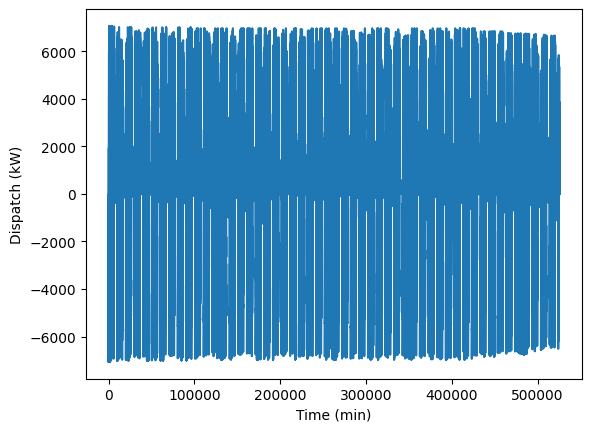

In [4]:
df = pd.read_csv("1min_batt_dispatch.csv")
batt_disp = df['pwr_kw:PythonPlugin:OutputVariable [](TimeStep)'].values

plt.plot(batt_disp)
plt.xlabel("Time (min)")
plt.ylabel("Dispatch (kW)")

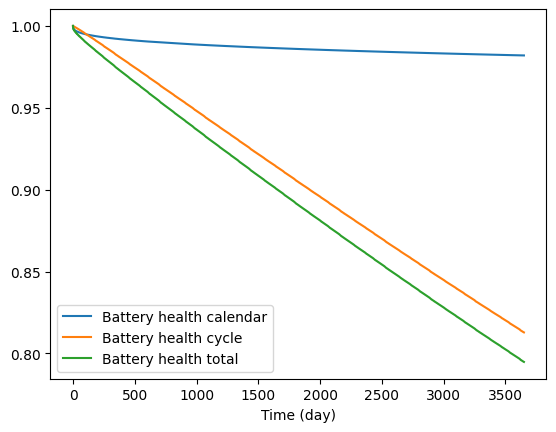

[1.         0.99892188 0.99845421 ... 0.79491949 0.79491658 0.7948508 ]
0


In [5]:
batt_config = {
  "batt_chem": "NMCGraphite",
  "initial_SOC": 50.0,
  "maximum_SOC": 90.0,
  "minimum_SOC": 10.0,
  "nominal_energy": 7000,
  "replacement_capacity": 0.5,
  "size_kw_to_size_kwh_ratio": 1
}
battery = setup_battery(batt_config)
life_model = NMCGrLifeModel(batt_config["nominal_energy"])
run_10_years(battery, batt_disp, life_model, batt_config)

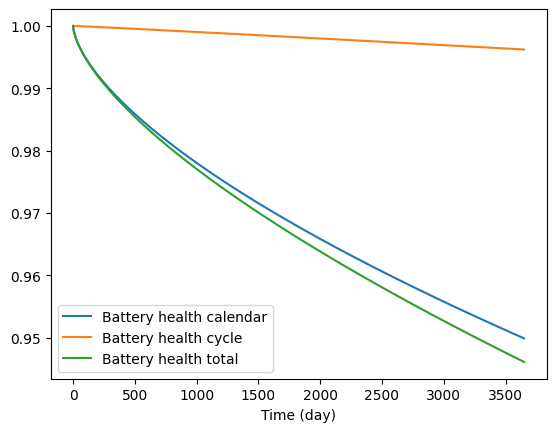

[1.         0.99973021 0.99955784 ... 0.94616624 0.94615748 0.94614732]
0


In [6]:
batt_config["batt_chem"] = "LMOLTO"
battery = setup_battery(batt_config)
life_model = LMOLTOLifeModel(batt_config["nominal_energy"])
run_10_years(battery, batt_disp, life_model, batt_config)